In [5]:
import io
import re
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import requests

try:
    import entsoe_secrets
    token = entsoe_secrets.token
    proxies = entsoe_secrets.proxies
except ImportError:
    # To get a token to use Entsoe RESTful API:
    # - first, register at https://transparency.entsoe.eu
    # - once registered, send an email to transparency@entsoe.eu with “Restful API access” in the subject line.
    #   Indicate the email address you entered during registration in the email body. 
    token = "put you token here"
    # If you are behind a corporate proxy, you have to define the following dict
    # proxies = {
    #     "http": "http://your_login:your_passwd@ip_address_of_proxy:port_number",
    #     "https": "http://your_login:your_passwd@ip_address_of_proxy:port_number"
    # }
    proxies = {}
colors = ["#006BA4", "#FF800E", "#ABABAB", "#595959", "#5F9ED1", "#C85200", "#898989", "#A2C8EC", "#FFBC79", "#CFCFCF"]

In [6]:
YEAR = 2021
EIC_CODES = {
    "FR": "10YFR-RTE------C",
    "ES": "10YES-REE------0",
    "PT": "10YPT-REN------W",
    "BE": "10YBE----------2",
    "DE": "10Y1001A1001A83F",
    "IT": "10YIT-GRTN-----B",
    "CH": "10YCH-SWISSGRIDZ",
    "UK": "10Y1001A1001A92E",
}
TSOS = ["ES", "FR", "PT"]

### Extract load data for ES, PT and FR (using RESTful API)

In [7]:
df = {}
progress = tqdm(TSOS, desc="Reading load", leave=True)
for tso in progress:
    progress.set_description(f"Reading load for {tso}", refresh=True)
    # Use the RESTful API to get the LOAD for each TSO
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A65&processType=A16&outBiddingZone_Domain={EIC_CODES[tso]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    # Extract the data from the response
    df[tso] = pd.read_xml(
        io.StringIO(s),
        xpath=".//xmlns:Point",
        namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"}
    )
    df_date_range = pd.read_xml(
        io.StringIO(s),
        xpath=".//xmlns:timeInterval",
        namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"},
        parse_dates=["start", "end"]
    )
    # Needed because sometimes there are missing values in the dataset
    idx = pd.Index([])
    for index, time_interval in df_date_range.iterrows():
        idx1 = pd.date_range(
            df_date_range.loc[index, "start"],
            df_date_range.loc[index, "end"],
            freq="H",
            inclusive="left"
        )
        idx = idx.union(idx1)
    df[tso]["idx"] = idx
    df[tso] = df[tso].set_index("idx")
    df[tso] = df[tso].reindex(pd.date_range(idx[0], idx[-1], freq="H", inclusive="both"))["quantity"].squeeze()

Reading load:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
loads = pd.DataFrame(df)
loads

,ES,FR,PT
2021-01-01 00:00:00+00:00,23436,64139.0,5598
2021-01-01 01:00:00+00:00,21319,62657.0,5136
2021-01-01 02:00:00+00:00,19606,59481.0,4654
2021-01-01 03:00:00+00:00,18753,57656.0,4327
2021-01-01 04:00:00+00:00,18566,57640.0,4153
...,...,...,...
2021-12-31 19:00:00+00:00,27661,54155.0,6507
2021-12-31 20:00:00+00:00,26551,51945.0,5958
2021-12-31 21:00:00+00:00,23743,52907.0,5387
2021-12-31 22:00:00+00:00,22220,54542.0,5096


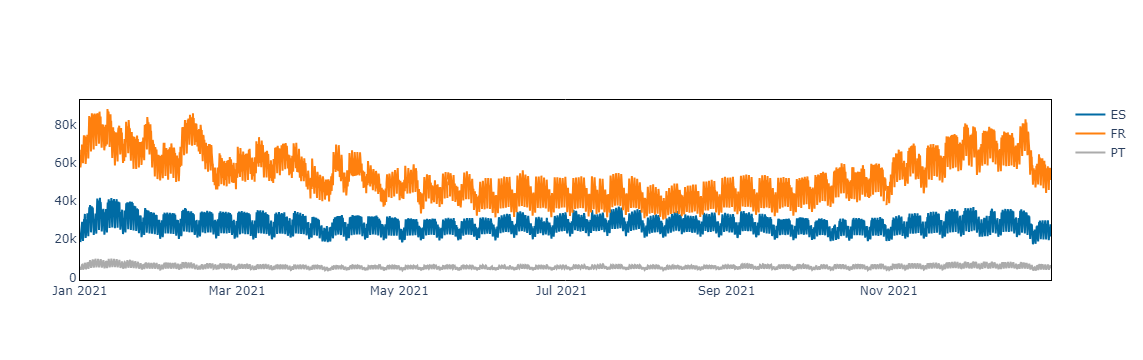

In [18]:
fig = go.Figure()
for idx, tso in enumerate(TSOS):
    fig.add_trace(
        go.Scatter(
            x=loads[tso].index,
            y=loads[tso].to_numpy(),
            mode='lines',
            name=tso,
            marker=dict(color=colors[idx])
        )
    )

fig.update_layout(
    plot_bgcolor='white'
)
fig.update_xaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.show()

In [ ]:
### Extract crossborder physical flows for ES, PT and FR (using RESTful API)

In [19]:
links = ["ES_FR", "FR_BE", "FR_CH", "FR_DE", "FR_IT", "FR_UK", "ES_PT"]
crossborder_exchanges = {}
progress = tqdm(links, desc="Reading crosborder exchanges", leave=True)
for link in progress:
    progress.set_description(f"Reading crossborder exchanges for {link}", refresh=True)
    tso1 = link.split("_")[0]
    tso2 = link.split("_")[1]
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A11&in_Domain={EIC_CODES[tso1]}&out_Domain={EIC_CODES[tso2]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    df1 = pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})["quantity"].squeeze()
    url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A11&in_Domain={EIC_CODES[tso2]}&out_Domain={EIC_CODES[tso1]}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"
    s = requests.get(url, proxies=proxies).text
    df2 = pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})["quantity"].squeeze()
    crossborder_exchanges[link] = df2 - df1

Reading crosborder exchanges:   0%|          | 0/7 [00:00<?, ?it/s]

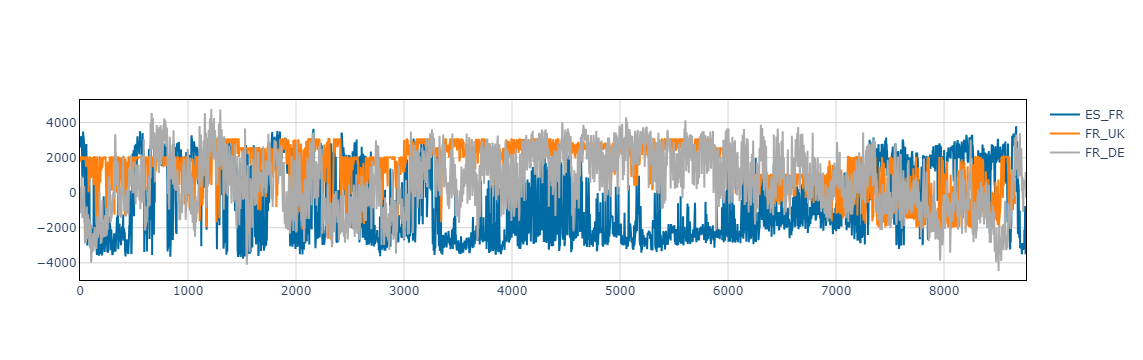

In [21]:
fig = go.Figure()
for idx, link in enumerate(["ES_FR", "FR_UK", "FR_DE"]):
    fig.add_trace(
        go.Scatter(
            x=crossborder_exchanges[link].index,
            y=crossborder_exchanges[link].to_numpy(),
            mode='lines',
            name=link,
            marker=dict(color=colors[idx])
        )
    )

fig.update_layout(
    plot_bgcolor='white'
)
fig.update_xaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.update_yaxes(
    mirror=True,
    linecolor='black',
    gridcolor='lightgrey'
)
fig.show()

In [ ]:
pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"})

In [ ]:
print(s)

In [ ]:
s = requests.get(url, proxies=proxies).text
pd.read_xml(io.StringIO(s), xpath=".//xmlns:Point", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:0"})

In [ ]:
pd.read_xml(io.StringIO(s), xpath=".//xmlns:MktPSRType", namespaces={"xmlns": "urn:iec62325.351:tc57wg16:451-6:generationloaddocument:3:0"})

In [ ]:
url = rf"https://web-api.tp.entsoe.eu/api?securityToken={token}&documentType=A75&processType=A16&in_Domain={EIC_CODES['ES']}&periodStart={YEAR}01010000&periodEnd={YEAR + 1}01010000"

In [9]:
base_folder = Path(r"D:\Users\guyfab\Documents\Codes\lfe_summit")

### Extract load data for ES, PT and FR

In [ ]:
tsos = ["ES", "FR", "PT"]
load = pd.concat(
    [
        pd.read_csv(
            base_folder / f"{tso}_Total Load - Day Ahead _ Actual_202101010000-202201010000.csv",
            sep=",",
            index_col=0,
            usecols=lambda x: x.startswith(("Time", "Actual Total Load")),
        )
        for tso in tsos
    ], axis=1
).reset_index(drop=True)
load = load.rename(columns={col: re.sub(r"[a-zA-Z \[\]-]*\((.*)\)", r'\1_load', col) for col in load.columns})

In [ ]:
generation = pd.concat(
    [
        pd.read_csv(
            base_folder / f"{tso}_Actual Generation per Production Type_202101010000-202201010000.csv",
            sep=",",
            index_col=0,
            na_values="n/e"
        )
        .reset_index(drop=True)
        .rename(columns=lambda x: tso + "_" + x)
        for tso in tsos
    ], axis=1
)

In [ ]:
for tso in tsos:
    generation[tso + "_total"] = generation.filter(regex=tso + ".*Aggregated").select_dtypes(include="number").sum(axis=1) - generation.filter(regex=tso + ".*Consumption").select_dtypes(include="number").sum(axis=1)

### Extract crossborder flows for ES, PT and FR

In [10]:
links = ["ES_FR", "FR_BE", "FR_CH", "FR_DE", "FR_IT", "FR_UK", "ES_PT"]
crossborders_flows = pd.concat(
    [
        pd.read_csv(base_folder / f"{link}_Cross-Border Physical Flow_202101010000-202201010000.csv", sep=",", index_col=0).reset_index(drop=True)
        for link in links
    ], axis=1
)
crossborders_flows = crossborders_flows.rename(columns={col: re.sub(r"[a-zA-Z ]*\((.*)\) > [a-zA-Z ]*\((.*)\) \[MW\]", r'\1_\2', col) for col in crossborders_flows.columns})

In [11]:
for link in links:
    crossborders_flows[link] = crossborders_flows[link] - crossborders_flows[link.split("_")[1] + "_" + link.split("_")[0]]
crossborders_flows = crossborders_flows[links]

In [12]:
crossborders_flows

,ES_FR,FR_BE,FR_CH,FR_DE,FR_IT,FR_UK,ES_PT
0,1731.0,-477.0,-542.0,-1235.0,371.0,2019.0,-320.0
1,2573.0,-645.0,-470.0,-1122.0,491.0,2019.0,-283.0
2,3176.0,-906.0,-358.0,-1189.0,262.0,2019.0,-98.0
3,3210.0,-159.0,92.0,-414.0,412.0,2019.0,334.0
4,3212.0,207.0,591.0,335.0,557.0,1819.0,1034.0
...,...,...,...,...,...,...,...
8756,-3503.0,-2088.0,941.0,431.0,2676.0,53.0,-2055.0
8757,-3517.0,-1776.0,1228.0,775.0,2720.0,-411.0,-1784.0
8758,-3079.0,-1386.0,1564.0,1182.0,2643.0,-616.0,-1327.0
8759,-1930.0,-1667.0,1180.0,441.0,2298.0,-266.0,-934.0


### Check that balances are correct for each TSO

In [ ]:
balance_es_p_c = generation["ES_total"] - load["ES_load"]
balance_es_exchanges =  crossborders_flows["ES_FR"] + crossborders_flows["ES_PT"]

In [ ]:
balance_pt_p_c = generation["PT_total"] - load["PT_load"]
balance_pt_exchanges =  -crossborders_flows["ES_PT"]

In [ ]:
balance_fr_p_c = generation["FR_total"] - load["FR_load"]
balance_fr_exchanges =  -crossborders_flows["ES_FR"] + crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"] 

In [ ]:
(crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"]).describe()

In [ ]:
(balance_es_p_c + balance_pt_p_c + balance_fr_p_c - (crossborders_flows["FR_BE"] + crossborders_flows["FR_DE"] + crossborders_flows["FR_CH"]+ crossborders_flows["FR_IT"] + crossborders_flows["FR_UK"])).describe()

In [ ]:
balance_fr_p_c

In [ ]:
(balance_pt_exchanges - balance_pt_p_c).describe()

In [ ]:
(balance_es_exchanges - balance_es_p_c).describe()

In [ ]:
gen_pt = gen["PT"].select_dtypes(include="number").sum(axis=1) - 2 * gen["PT"]["Hydro Pumped Storage  - Actual Consumption [MW]"]
load_pt = load["PT"].squeeze()

In [ ]:
balance = exchanges["Portugal (PT) > Spain (ES) [MW]"] - exchanges["Spain (ES) > Portugal (PT) [MW]"]

In [ ]:
(gen_pt - load_pt).dropna().plot()